# Problem 1: Bayesian Density Estimation
By: Griffin Hosseinzadeh (2025 May 6)  
Inspired by a notebook by LM Walkowicz (2019 June 14)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.visualization as viz
from scipy import stats
from sklearn.neighbors import KernelDensity

Here I'm simulating some data. Just run this cell to generate a list of values `x`.

In [3]:
x = np.concatenate([stats.cauchy(-5, 1.8).rvs(500),
                    stats.cauchy(-4, 0.8).rvs(2000),
                    stats.cauchy(-1, 0.3).rvs(500),
                    stats.cauchy(2, 0.8).rvs(1000),
                    stats.cauchy(4, 1.5).rvs(500)])

# truncate values to a reasonable range
x = x[(x > -15) & (x < 15)]



Make a histogram of these values using `plt.hist`. (Use `density=True` throughout this exercise, so the y-axes are comparable.) How many peaks does this data set have?

(array([0.00434821, 0.00729878, 0.02243988, 0.12151697, 0.06801845,
        0.06491258, 0.03393158, 0.00737643, 0.00318351, 0.00194117]),
 array([-14.89505252, -11.9096887 ,  -8.92432488,  -5.93896105,
         -2.95359723,   0.03176659,   3.01713041,   6.00249423,
          8.98785805,  11.97322187,  14.95858569]),
 <BarContainer object of 10 artists>)

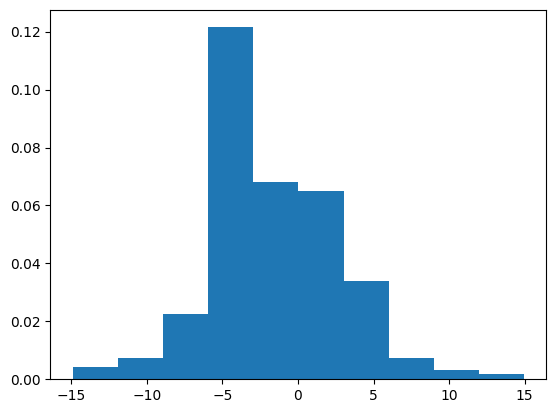

In [4]:
plt.hist(x,density=True)

Answer: There appears need to be 1 main peak

Now make a histogram using the `'auto'` binning in Matplotlib. What does it think the right number of bins should be? How many peaks does this data set have?

42 bins


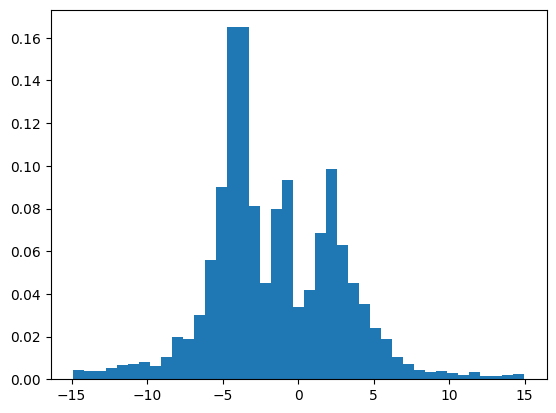

In [5]:
n, b, p = plt.hist(x, density=True,bins='auto')
print(len(b), 'bins')

Answer: Now the data has 3 distinct peaks , and matplotlib thinks the right number of bins is 42

Increase the number of bins even further. Is there a point where it gets too high? If so, why?

(array([0.03105865, 0.        , 0.        , ..., 0.        , 0.        ,
        0.03105865], shape=(4000,)),
 array([-14.89505252, -14.88758911, -14.8801257 , ...,  14.94365887,
         14.95112228,  14.95858569], shape=(4001,)),
 <BarContainer object of 4000 artists>)

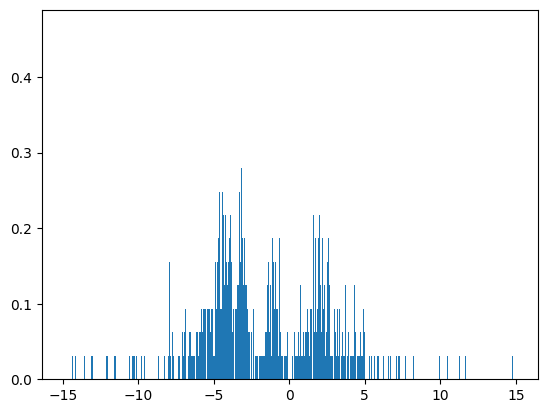

In [6]:
plt.hist(x, density=True, bins=4000)

Answer: Once I start hitting 2000+ bins it becomes unreasonable to keep increasing them since the gaps between data points start to make it un readable and i assume eventually they will all turn into dirac deltas and disapear

Now make a histogram using Bayesian blocks. Hint: try the `astropy.visualization.hist` function. How many bins does this have? Can you see all the peaks?

19 bins


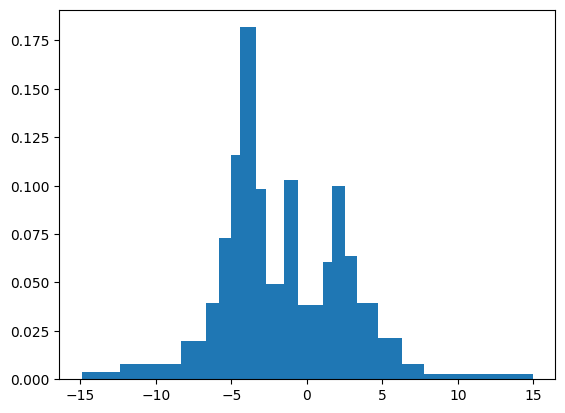

In [7]:
n, b, p = viz.hist(x, density=True, bins='blocks')
print(len(b), 'bins')

Answer: It has 19 bins and we can see all 3 peaks


Try making the Bayesian blocks histogram *without* `density=True`. What do you notice? Is this a good idea?

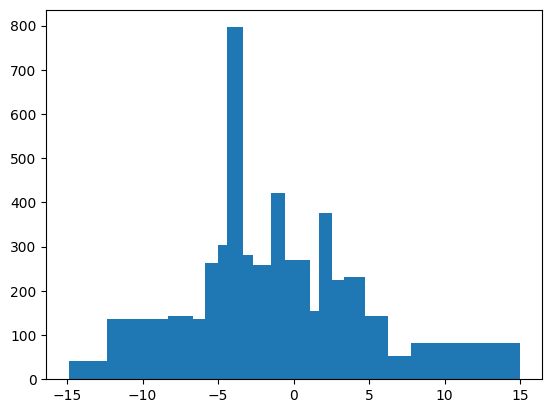

In [8]:
viz.hist(x, bins='blocks');

Answer: We almost get a sense of all three peaks but its not quite there 

Now let's try making a KDE instead. Try a few different values for the bandwidth until you find one you like.

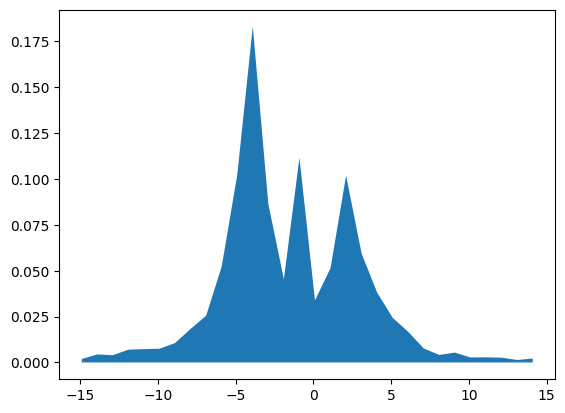

In [9]:
kde = KernelDensity(bandwidth=0.2,kernel='gaussian') # complete
kde.fit(x.reshape(-1,1))

x_fit = np.arange(min(x),max(x)) # complete
y_fit =  np.exp(kde.score_samples(x_fit.reshape(-1,1)))
plt.fill_between(x_fit,y_fit)

Plot all of these density estimates on top of each other using `histtype='step'` and compare them.

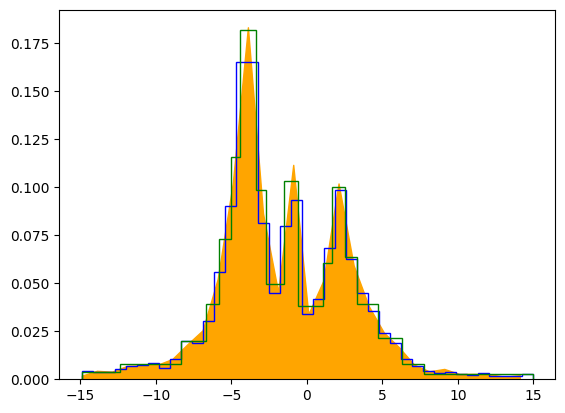

In [10]:
plt.fill_between(x_fit,y_fit , color='orange')
plt.hist(x, density=True,bins='auto',histtype='step',color='blue')
n, b, p = viz.hist(x, density=True, bins='blocks',histtype='step',color='green')

# Problem 2: Gaussian Process Regression
By: Griffin Hosseinzadeh (2019 April 17)  
Updated 2025 May 6

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import george
from astropy.table import Table
import math

## Read the Light Curve
I have given you light curve data for the Type Ibn supernova PTF11rfh in the file `PTF11rfh.table`, which is readable with the `astropy.table` module. (Hint: `format='ascii.fixed_width'`.) For this example, let's fit the light curve in counts rather than magnitudes. Select only points observed in the $r$ or $R$ filter and have a measurement in counts. Plot it to see what we're working with. (For non-astronomers, MJD is a measure of time in days.)

In [12]:
data =  Table.read('PTF11rfh.table',format='ascii.fixed_width')

data_df = data.to_pandas()
data_df =  data_df[data_df['filt']=='R' ]
data_df =  data_df[~np.isnan(data_df['counts'])]

data= Table.from_pandas(data_df)
data


MJD,counts,dcounts,zp,nondet,filt,source,mag,dmag,limmag,flam,dflam
float64,float64,float64,float64,str5,str1,str3,float64,float64,float64,float64,float64
55889.091,19.7,36.8,27.0,True,R,P48,21.89257731651705,--,--,--,--
55889.125,22.2,45.1,27.0,True,R,P48,21.671755508505942,--,--,--,--
55889.167,-7.8,49.6,27.0,True,R,P48,21.56849267197535,--,--,--,--
55891.167,-17.1,54.8,27.0,True,R,P48,21.46024546698992,--,--,--,--
55892.099,99.8,107.9,27.0,True,R,P48,20.724643251493568,--,--,--,--
55892.142,-128.1,64.0,27.0,True,R,P48,21.291746928241125,--,--,--,--
55892.178,-13.6,107.1,27.0,True,R,P48,20.732723186121206,--,--,--,--
55893.098,-57.5,56.9,27.0,True,R,P48,21.419416197213167,--,--,--,--
55893.136,-85.3,64.3,27.0,True,R,P48,21.28666943089029,--,--,--,--


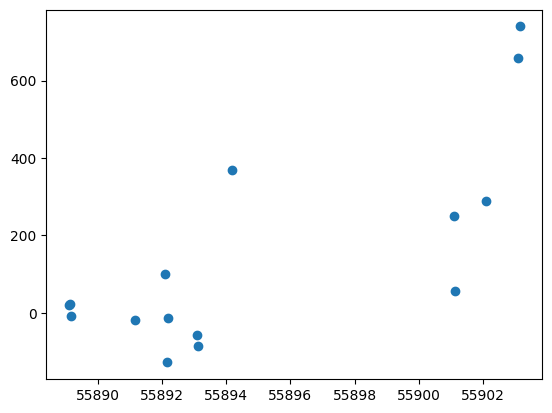

In [ ]:
x =  data['MJD']
y =  data['counts']
dy =  data['dcounts']
plt.scatter(x,y)

<ErrorbarContainer object of 3 artists>

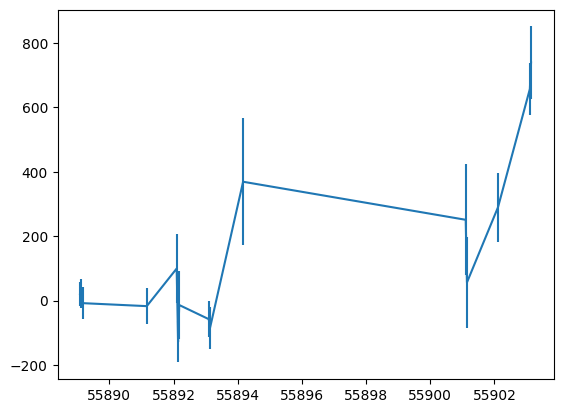

In [18]:
plt.errorbar(x,y,yerr=dy)


## Try a Polynomial Fit
Hint: use `np.polyfit` and `np.polyval`. Try different degree polynomials to see if you are able to get a good fit.

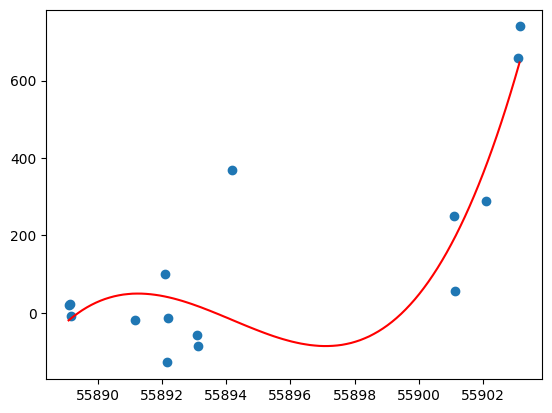

In [37]:
x_fit =  np.linspace(min(x), max(x), 100)
# complete
y_fit_poly = np.polyfit(x,y,3)

y_plot = np.polyval(y_fit_poly, x_fit)  # Evaluate polynomial at each x point
plt.scatter(x, y)  # Plot original data
plt.plot(x_fit, y_plot, 'r-')  # Plot the polynomial fit

Don't spend too much time on this. I could not get it to give a reasonable result.

## Try a Gaussian Process
We are using a package called `george` to make Gaussian process regression easier. It has all of the functions you need build in.

First we need to initialize a kernel (`george.kernels`). You should normalize the kernel by the total variance of the data points. Think about what hyperparameters would be appropriate for fitting your data. We can always optimize them later.

In [39]:
kernel =  np.var(y) * george.kernels.ExpSquaredKernel(0.5) 

Initialize a Gaussian process with the kernel you chose. This is all contained within the `george.GP` object, which we will use for the remainder of the calculations.

In [40]:
gp =  george.GP(kernel)

The first step is to precompute the covariance matrix at the observed times.

In [43]:
gp.compute(x,dy)

The second and last step is to use the Gaussian process to predict the light curve at the times in `x_fit`, given the observed data points in `y`. This should give you an interpolation **and** and uncertainty on the interpolation.

In [46]:
x_pred = np.linspace(min(x), max(x), 500)
pred, pred_var = gp.predict(y, x_pred)

Plot the results of your Gaussian process fit and compare to the data and the polynomial fit. Hint: display the uncertainties using `plt.fill_between`.

/tmp/ipykernel_465/3654571803.py:4: RuntimeWarning: invalid value encountered in sqrt
  pred_std = np.sqrt(pred_var)


ValueError: 'y1' is not 1-dimensional

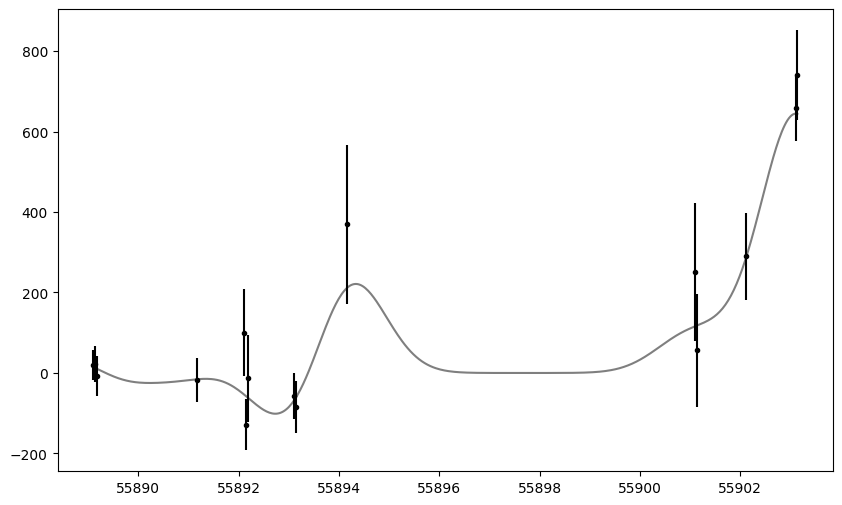

In [ ]:
plt.figure(figsize=(10, 6))
plt.errorbar(x, y, yerr=dy, fmt=".k", capsize=0)
plt.plot(x_pred, pred, "k", lw=1.5, alpha=0.5)

# For the fill_between, use the mean prediction ± standard deviation
plt.fill_between(x_pred, y1= # Upper bound
                 color="k", alpha=0.2)
plt.xlabel("MJD")
plt.ylabel("Counts")

Once you get a reasonable fit, try adjusting the kernel and/or hyperparameters to see what effects they have.

## Take-Away Message
Gaussian process regression is a very easy and powerful way to interpolate an arbitrary set of data points with a nonparametric function. Furthermore, it gives you uncertainties on the interpolation and handles covariance between points correctly.

## Other Things to Try (Optional)
- Optimize the Gaussian process using the technique described in the George tutorial: https://george.readthedocs.io/en/latest/tutorials/first/.
- Marginalize over the hyperparameter(s) using MCMC.
- Try products of different kernels to see if you can get a better fit.